In [1]:
#!wget http://158.109.8.102/AppaRealAge/appa-real-release.zip

In [2]:
#!unzip appa-real-release.zip

In [3]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv('/content/appa-real-release/gt_avg_train.csv')
test = pd.read_csv('/content/appa-real-release/gt_avg_test.csv')
display(train.head())
display(test.head())

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,000000.jpg,36,5.000000,1.146423,4
1,000001.jpg,63,20.079365,4.096819,18
2,000002.jpg,38,76.815789,6.133009,80
3,000003.jpg,38,55.657895,7.864653,50
4,000004.jpg,15,17.666667,3.457222,17


,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,005613.jpg,39,23.205128,5.530678,19
1,005614.jpg,38,70.736842,6.570549,76
2,005615.jpg,38,55.368421,5.874457,40
3,005616.jpg,36,24.277778,2.224681,21
4,005617.jpg,39,25.230769,5.691460,34


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


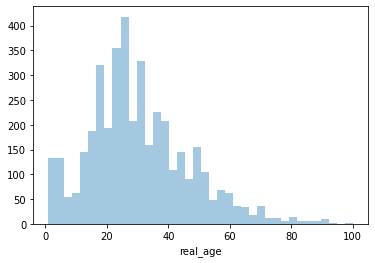

In [5]:
sns.distplot(train['real_age'], kde=False)

In [6]:
DATA_PATH = '/content/appa-real-release/'

In [7]:
!pip install pretrainedmodels

In [8]:
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.utils.data
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pretrainedmodels
import pretrainedmodels.utils

In [9]:
!pip install albumentations==0.4.6

In [10]:
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, RandomRotate90, CoarseDropout, OpticalDistortion, HueSaturationValue, RandomBrightnessContrast
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [11]:
def get_model(model_name="se_resnext50_32x4d", num_classes=101, pretrained="imagenet"):
    model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
    dim_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(dim_feats, num_classes)
    return model

In [12]:
class FaceDataset(Dataset):
    def __init__(self, data_dir, data_type, transform=False):
        csv_path = Path(data_dir).joinpath(f"gt_avg_{data_type}.csv")
        img_dir = Path(data_dir).joinpath(data_type)
        self.transform = transform

        self.x = []
        self.y = []
        df = pd.read_csv(str(csv_path))
        for _, row in df.iterrows():
             img_name = row["file_name"]

             img_path = img_dir.joinpath(img_name + "_face.jpg")
             self.x.append(str(img_path))
             self.y.append(row["real_age"])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]
        img = cv2.imread(str(img_path), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
        if self.transform:
            augmented = self.transform(image=img)
            image = augmented['image']
        else:
            image = img
        label = np.clip(round(age), 0, 100)
        return image, label

In [13]:
train_dataset = FaceDataset(DATA_PATH, 'train', transform=None)

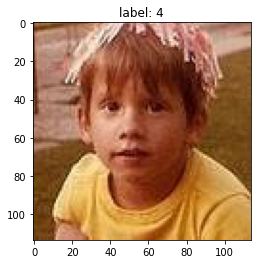

In [14]:
for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [30]:
def get_transforms(*, data):
    num_holes = 12
    max_width = int(((224*224)/(num_holes*5))**(1/2))
    if data == 'train':
        return Compose([
            Resize(224, 224),
            #CoarseDropout(num_holes, max_width, max_width, p=0.5),
            #RandomResizedCrop(224, 224),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            #ShiftScaleRotate(p=0.5),
            #HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(224, 224),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

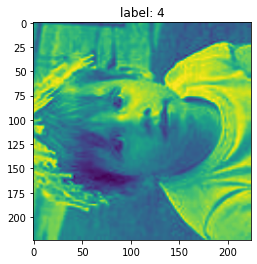

In [31]:
train_dataset = FaceDataset(DATA_PATH, 'train', transform=get_transforms(data='train'))
for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [32]:
class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val
        self.count += n
        self.avg = self.sum / self.count

In [33]:
epoch = 20

In [34]:
model = get_model(model_name='se_resnet50')

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
device

'cuda'

In [37]:
model = model.to(device)

In [38]:
criterion = nn.CrossEntropyLoss().to(device)
train_dataset = FaceDataset(DATA_PATH, 'train', transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          num_workers=4, drop_last=True)

In [39]:
val_dataset = FaceDataset(DATA_PATH, 'valid', transform=get_transforms(data='valid'))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=False)

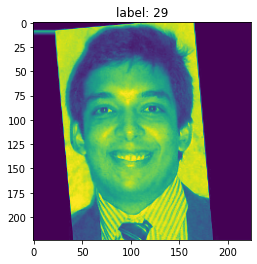

In [40]:
for i in range(1):
    image, label = val_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [41]:
scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=3,eps=1e-6)

In [42]:
best_val_mae = 10000.0
start_epoch = 0

In [43]:
checkpoint_dir = Path('checkpoint')
checkpoint_dir.mkdir(parents=True, exist_ok=True)

In [44]:
for epoch in range(start_epoch, epoch):

    model.train()
    losses = AverageMeter()
    with tqdm(train_loader) as tq:
        for x, y in tq:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            ll = loss.item()
            losses.update(ll, x.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tq.set_postfix(OrderedDict(stage="train", epoch=epoch, loss=losses.avg))

    model.eval()
    losses = AverageMeter()
    preds = []
    gt = []
    with torch.no_grad():
        with tqdm(val_loader) as tqv:
            for i, (x, y) in enumerate(tqv):
                x = x.to(device)
                y = y.to(device)
                outputs = model(x)
                preds.append(F.softmax(outputs, dim=-1).cpu().numpy())
                gt.append(y.cpu().numpy())
                if criterion is not None:
                    loss = criterion(outputs, y)
                    ll = loss.item()
                    losses.update(ll, x.size(0))
                    tqv.set_postfix(OrderedDict(stage="val", epoch=epoch, loss=losses.avg))

    preds = np.concatenate(preds, axis=0)
    gt = np.concatenate(gt, axis=0)
    ages = np.arange(0, 101)
    ave_preds = (preds * ages).sum(axis=-1)
    diff = ave_preds - gt
    mae = np.abs(diff).mean()

    if mae < best_val_mae:
        print(f"=> [epoch {epoch:03d}] best val mae was improved from {best_val_mae:.3f} to {mae:.3f}")
        model_state_dict = model.state_dict()
        torch.save(
            {
                'epoch': epoch + 1,
                'arch': 'se_resnet50',
                'state_dict': model_state_dict,
                'optimizer_state_dict': optimizer.state_dict()
            },
            str(checkpoint_dir.joinpath("epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, losses.avg, mae)))
        )
        best_val_mae = mae
    else:
        print(f"=> [epoch {epoch:03d}] best val mae was not improved from {best_val_mae:.3f} ({mae:.3f})")

    scheduler.step(losses.avg)

100%|██████████| 24/24 [00:08<00:00,  2.73it/s, stage=val, epoch=0, loss=0.0668]


=> [epoch 000] best val mae was improved from 10000.000 to 12.160


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 001] best val mae was not improved from 12.160 (12.477)


100%|██████████| 24/24 [00:08<00:00,  2.72it/s, stage=val, epoch=2, loss=0.062]


=> [epoch 002] best val mae was improved from 12.160 to 10.253


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 003] best val mae was not improved from 10.253 (11.360)


100%|██████████| 24/24 [00:08<00:00,  2.74it/s, stage=val, epoch=4, loss=0.0633]


=> [epoch 004] best val mae was improved from 10.253 to 10.156


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 005] best val mae was not improved from 10.156 (10.412)


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 006] best val mae was not improved from 10.156 (10.643)


100%|██████████| 24/24 [00:08<00:00,  2.80it/s, stage=val, epoch=7, loss=0.0595]


=> [epoch 007] best val mae was improved from 10.156 to 8.619


100%|██████████| 24/24 [00:08<00:00,  2.73it/s, stage=val, epoch=8, loss=0.0598]


=> [epoch 008] best val mae was improved from 8.619 to 8.487


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 009] best val mae was not improved from 8.487 (8.589)


100%|██████████| 24/24 [00:08<00:00,  2.73it/s, stage=val, epoch=10, loss=0.061]


=> [epoch 010] best val mae was improved from 8.487 to 8.147


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 011] best val mae was not improved from 8.147 (8.149)


100%|██████████| 24/24 [00:08<00:00,  2.73it/s, stage=val, epoch=12, loss=0.0631]


=> [epoch 012] best val mae was improved from 8.147 to 7.981


100%|██████████| 24/24 [00:08<00:00,  2.74it/s, stage=val, epoch=13, loss=0.0645]


=> [epoch 013] best val mae was improved from 7.981 to 7.976


100%|██████████| 24/24 [00:08<00:00,  2.77it/s, stage=val, epoch=14, loss=0.0657]


=> [epoch 014] best val mae was improved from 7.976 to 7.891


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 015] best val mae was not improved from 7.891 (7.945)


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 016] best val mae was not improved from 7.891 (7.966)


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 017] best val mae was not improved from 7.891 (7.956)


  0%|          | 0/64 [00:00<?, ?it/s]

=> [epoch 018] best val mae was not improved from 7.891 (7.960)


100%|██████████| 24/24 [00:08<00:00,  2.72it/s, stage=val, epoch=19, loss=0.0685]

=> [epoch 019] best val mae was not improved from 7.891 (8.011)


In [45]:
print(f"best val mae: {best_val_mae:.3f}")

best val mae: 7.891
